In [1]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/lightautoml/ml_algo/dl_model.py:42: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/lightautoml/text/embed.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/lightautoml/text/dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


In [2]:
N_THREADS = 8
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.1
TIMEOUT = 2100

In [3]:
start_db = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Target_dataset/Organic_compound_final_dataset.csv") # load organic compounds dataset
change_nm = start_db['Absorption max (nm)']
change_em = start_db['Emission max (nm)']
metal = pd.read_excel("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Target_dataset/Metal_complexes_dataset.xlsx")
change_nm_metal = metal['Absorption_nm']
change_em_metal = metal['Emission_nm']

In [5]:
CM_comp = [f'CM_{i}' for i in range(100)]
CM_solv = [f'CM_solv_{i}' for i in range(100)]
morgan_lig_1 = [f'Morgan_lig_1_{i}' for i in range(2048)]
morgan_lig_2 = [f'Morgan_lig_2_{i}' for i in range(2048)]
morgan_solv = [f'Morgan_solv_{i}' for i in range(2048)]
tda_comp = [f'Topol_{i}' for i in range(12)]
tda_solv = [f'Topol_solv_{i}' for i in range(12)]
cm_col = CM_comp + CM_solv + morgan_lig_1 + morgan_lig_2 + morgan_solv + tda_comp + tda_solv 

In [7]:
CM_small = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compounds_descriptors/Organic_compounds_coulomb_matrix_10x10.csv") # load datasets CM 10*10 for organic compounds dataset
tda_full = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_organic_compounds.csv") # load topologies feature for organic compounds dataset
morgan_org = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compounds_descriptors/Organic_compounds_Morgan_FingerPrints.csv") # load morgan fingerprints for organic compounds dataset
CM_small_metal = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/Metal_complexes_coulomb_matrix_10x10.csv') # load datasets CM 10*10 for metal complexs dataset
tda_metal = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Topology/Topology_features_metal_complex.csv")  # load topologies feature for metal complexs dataset
morgan_ligand = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Metal_complexes_descriptors/Metal_complexes_ligands_MorganFingerprints_2048.csv') # load morgan fingerprints for metal complexs dataset

In [10]:
CM_small_morgan_tda_db = pd.concat([CM_small, morgan_org.loc[:,"Morgan_0":"Morgan_2047"], morgan_org, tda_full],axis=1).drop(['Unnamed: 0'],axis=1) # we are need to make to morgans for two ligands in future metal complex
CM_small_morgan_tda_db = pd.DataFrame(np.array(CM_small_morgan_tda_db), columns = cm_col)
CM_small_morgan_tda_db_abs = pd.concat([CM_small_morgan_tda_db, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop_duplicates() # create combination for organic compounds dataset
CM_small_morgan_tda_db_abs        

,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_4,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Absorption,Molecular weight (g mol-1)
0,73.516695,27.997891,13.467240,34.439686,34.058083,19.706623,11.124118,13.091766,19.696135,20.029354,...,0.000000,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,355.0,187.15370
1,73.516695,27.976892,13.455964,34.530841,34.017921,12.919381,19.725661,11.123532,19.688135,19.965660,...,0.000000,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,408.0,186.14576
2,73.516695,6.107871,5.398309,13.943743,24.061300,5.029020,39.173405,4.702785,13.554128,4.404038,...,0.000000,0.0,0.293662,0.0,0.0,1.368031,0.0,0.0,526.0,1061.54348
3,388.023441,30.379379,43.541950,55.501462,55.725541,34.437376,37.779617,24.568054,17.790142,18.827344,...,0.000000,0.0,0.139617,0.0,0.0,1.602776,0.0,0.0,514.0,350.42028
4,388.023441,30.388456,43.540829,55.501775,55.726173,34.440258,37.779407,24.573775,17.791966,18.830626,...,0.000000,0.0,0.301253,0.0,0.0,2.171758,0.0,0.0,524.0,350.42028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231,73.516695,10.267818,16.646469,39.624299,19.861808,13.674789,10.760305,15.596302,13.766413,10.062342,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,358.0,350.41992
20232,73.516695,10.325772,16.646947,39.627875,19.882118,13.664842,10.783155,15.647763,13.763316,10.051933,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,348.0,364.44680
20233,73.516695,10.593539,17.318980,39.597928,11.141309,19.911880,16.256344,13.408664,9.924419,20.379432,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,344.0,414.50668
20234,73.516695,10.327494,16.669343,39.627625,19.884228,13.664314,10.785643,15.652863,10.053468,13.757893,...,0.815529,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,346.0,414.50668


In [11]:
CM_small_morgan_tda_metal_db = pd.concat([CM_small_metal, morgan_ligand, tda_metal],axis=1).drop(['Unnamed: 0'],axis=1)
CM_small_morgan_tda_metal_db = pd.DataFrame(np.array(CM_small_morgan_tda_metal_db), columns = cm_col)
CM_small_morgan_tda_metal_db_abs = pd.concat([CM_small_morgan_tda_metal_db, pd.DataFrame({'Absorption':change_nm_metal}),pd.DataFrame({'Molecular weight (g mol-1)':metal['Molecular_Mass']})], axis=1).dropna()# create combination for metal complexs dataset
CM_small_morgan_tda_metal_db_abs

,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_4,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Absorption,Molecular weight (g mol-1)
0,2539.412838,270.966531,215.276637,136.220422,93.609180,38.854105,92.927457,111.344087,42.301601,29.531147,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,520.0,647.89
1,73.516695,15.054500,10.014940,13.638080,13.700124,9.405533,17.113171,35.408924,34.893745,19.890595,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,498.0,332.31
2,6874.357145,617.556349,463.511594,301.532280,126.998954,90.356505,89.155097,80.452742,135.278308,58.318047,...,0.0,0.0,0.195697,0.0,0.0,1.778881,0.0,0.0,559.0,973.67
3,73.516695,15.309234,10.058564,11.815585,11.816455,9.452250,35.254072,35.257641,17.130556,19.873615,...,0.0,0.0,0.195697,0.0,0.0,1.778881,0.0,0.0,542.0,443.56
4,73.516695,23.297689,21.345900,21.089518,13.898475,28.168229,12.615223,13.109155,15.987225,12.502082,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,443.0,558.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,17377.890277,308.799417,294.131720,272.952488,237.287429,162.636681,163.262800,158.736663,157.993586,155.082690,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,386.0,448.37
93,17377.890277,308.825398,295.387922,273.032726,237.908170,134.021212,163.518341,162.185660,130.942418,158.669671,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,380.0,484.35
94,17377.890277,308.800776,294.068390,273.019709,236.991863,163.087298,162.545875,158.788225,158.057868,155.110375,...,0.0,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,420.0,478.40
97,15315.321984,310.914143,305.738002,306.806365,301.431842,270.712777,201.646831,153.443462,152.644146,147.174951,...,0.0,0.0,0.286546,0.0,0.0,0.683686,0.0,0.0,407.0,1010.82


In [12]:
train_data, test_data = train_test_split(
    CM_small_morgan_tda_metal_db_abs, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (86, 6370), test_data = (10, 6370)


,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_4,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Absorption,Molecular weight (g mol-1)
64,16847.976371,262.916521,262.929542,243.987467,243.955542,229.023064,229.010584,158.711805,158.666854,158.162485,...,0.000000,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,435.0,808.97
30,53.358707,17.683231,17.304577,29.833552,29.836681,17.303809,10.004057,29.373118,11.269704,6.515320,...,0.539143,0.0,0.496609,0.456798,0.0,2.428278,0.765767,0.0,343.0,434.53
18,53.358707,17.418504,10.006604,17.202145,30.008210,17.229134,11.258853,17.232771,10.695381,29.933151,...,0.000000,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,359.0,788.90
4,73.516695,23.297689,21.345900,21.089518,13.898475,28.168229,12.615223,13.109155,15.987225,12.502082,...,0.000000,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,443.0,558.54
31,4398.012181,149.081970,149.041113,149.018866,149.023344,148.962230,148.908561,90.162180,90.143838,90.135041,...,0.000000,0.0,0.000123,0.000000,0.0,0.693147,0.000000,0.0,452.0,569.62


In [13]:
CM_Abs_metal = CM_small_morgan_tda_db_abs.append(train_data)
CM_Abs_metal = CM_Abs_metal.append(train_data) 
train_data = CM_Abs_metal.append(train_data) 

/tmp/ipykernel_3639421/1275138815.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CM_Abs_metal = CM_small_morgan_tda_db_abs.append(train_data)
/tmp/ipykernel_3639421/1275138815.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CM_Abs_metal = CM_Abs_metal.append(train_data)
/tmp/ipykernel_3639421/1275138815.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = CM_Abs_metal.append(train_data)


# Create model

In [14]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)
task = Task('reg')
roles = {
    'target': 'Absorption'
}
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    gpu_ids='0',
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)


In [15]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[23:11:33] Stdout logging level is INFO.
[23:11:33] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:11:33] Task: reg

[23:11:33] Start automl preset with listed constraints:
[23:11:33] - time: 2100.00 seconds
[23:11:33] - CPU: 8 cores
[23:11:33] - memory: 16 GB

[23:11:33] Train data shape: (20463, 6370)

[23:12:05] Layer 1 train process start. Time left 2067.40 secs
[23:12:13] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:12:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1451.8465697638421
[23:12:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:12:53] Time left 2019.14 secs

[23:13:26] Selector_LightGBM fitting and predicting completed
[23:13:30] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:14:56] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -882.612004111224
[23:14:56] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:14:56] Start hyperparameters optimization for Lv

In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
y_test_solv = test_data['Absorption']
y_pred = automl.predict(test_data)
print(f'MRE : {mean_absolute_percentage_error((y_test_solv), y_pred.data)}')
print(f'MAE : {mean_absolute_error((y_test_solv), y_pred.data)}')
print(f'RMSE : {mean_squared_error((y_test_solv), y_pred.data, squared=False)}')

MRE : 0.06672915177750953
MAE : 34.8664306640625
RMSE : 56.941609201763406


/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
import pickle

# Assuming model is your trained LightAutoML model
with open('lightautoml_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi

In [22]:
fast_fi.head(20)

,Feature,Importance
0,Morgan_lig_1_463,9.833667e+08
1,Molecular weight (g mol-1),3.517861e+08
2,Topol_1,6.386901e+07
3,Morgan_lig_2_463,5.805393e+07
4,Topol_10,5.654375e+07
5,Morgan_lig_1_554,4.630744e+07
6,Topol_5,3.999858e+07
7,Morgan_lig_1_547,3.221397e+07
8,Morgan_lig_1_1317,3.168666e+07
9,Topol_0,2.969586e+07


# Em with abs

In [8]:
CM_small_morgan_tda_db = pd.concat([CM_small, morgan_org.loc[:,"Morgan_0":"Morgan_2047"], morgan_org, tda_full],axis=1).drop(['Unnamed: 0'],axis=1) # we are need to make to morgans for two ligands in future metal complex
CM_small_morgan_tda_db = pd.DataFrame(np.array(CM_small_morgan_tda_db), columns = cm_col)
CM_small_morgan_tda_db_em = pd.concat([CM_small_morgan_tda_db, pd.DataFrame({'Emission':change_nm_em}), pd.DataFrame({'Absorption':change_nm}), pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop_duplicates() # create combination for organic compounds dataset
CM_small_morgan_tda_db_em        

,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Emission,Absorption,Molecular weight (g mol-1)
0,73.516695,27.997891,13.467240,34.439686,34.058083,19.706623,11.124118,13.091766,19.696135,20.029354,...,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,410.000000,355.0,187.15370
1,73.516695,27.976892,13.455964,34.530841,34.017921,12.919381,19.725661,11.123532,19.688135,19.965660,...,0.0,0.000561,0.0,0.0,0.693147,0.0,0.0,450.000000,408.0,186.14576
2,73.516695,6.107871,5.398309,13.943743,24.061300,5.029020,39.173405,4.702785,13.554128,4.404038,...,0.0,0.293662,0.0,0.0,1.368031,0.0,0.0,535.000000,526.0,1061.54348
3,388.023441,30.379379,43.541950,55.501462,55.725541,34.437376,37.779617,24.568054,17.790142,18.827344,...,0.0,0.139617,0.0,0.0,1.602776,0.0,0.0,553.720000,514.0,350.42028
4,388.023441,30.388456,43.540829,55.501775,55.726173,34.440258,37.779407,24.573775,17.791966,18.830626,...,0.0,0.301253,0.0,0.0,2.171758,0.0,0.0,555.000000,524.0,350.42028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231,73.516695,10.267818,16.646469,39.624299,19.861808,13.674789,10.760305,15.596302,13.766413,10.062342,...,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,500.243574,358.0,350.41992
20232,73.516695,10.325772,16.646947,39.627875,19.882118,13.664842,10.783155,15.647763,13.763316,10.051933,...,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,500.243574,348.0,364.44680
20233,73.516695,10.593539,17.318980,39.597928,11.141309,19.911880,16.256344,13.408664,9.924419,20.379432,...,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,460.000000,344.0,414.50668
20234,73.516695,10.327494,16.669343,39.627625,19.884228,13.664314,10.785643,15.652863,10.053468,13.757893,...,0.0,0.143131,0.0,0.0,2.072589,-0.0,0.0,500.243574,346.0,414.50668


In [9]:
CM_small_morgan_tda_metal_db = pd.concat([CM_small_metal, morgan_ligand, tda_metal],axis=1).drop(['Unnamed: 0'],axis=1)
CM_small_morgan_tda_metal_db = pd.DataFrame(np.array(CM_small_morgan_tda_metal_db), columns = cm_col)
CM_small_morgan_tda_metal_db_em = pd.concat([CM_small_morgan_tda_metal_db, pd.DataFrame({'Emission':change_nm_metal}), pd.DataFrame({'Absorption':change_nm_metal}), pd.DataFrame({'Molecular weight (g mol-1)':metal['Molecular_Mass']})], axis=1).dropna()# create combination for metal complexs dataset
CM_small_morgan_tda_metal_db_em

,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Emission,Absorption,Molecular weight (g mol-1)
0,2539.412838,270.966531,215.276637,136.220422,93.609180,38.854105,92.927457,111.344087,42.301601,29.531147,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,520.0,520.0,647.89
1,73.516695,15.054500,10.014940,13.638080,13.700124,9.405533,17.113171,35.408924,34.893745,19.890595,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,498.0,498.0,332.31
2,6874.357145,617.556349,463.511594,301.532280,126.998954,90.356505,89.155097,80.452742,135.278308,58.318047,...,0.0,0.195697,0.0,0.0,1.778881,0.0,0.0,559.0,559.0,973.67
3,73.516695,15.309234,10.058564,11.815585,11.816455,9.452250,35.254072,35.257641,17.130556,19.873615,...,0.0,0.195697,0.0,0.0,1.778881,0.0,0.0,542.0,542.0,443.56
4,73.516695,23.297689,21.345900,21.089518,13.898475,28.168229,12.615223,13.109155,15.987225,12.502082,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,443.0,443.0,558.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,17377.890277,308.799417,294.131720,272.952488,237.287429,162.636681,163.262800,158.736663,157.993586,155.082690,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,386.0,386.0,448.37
93,17377.890277,308.825398,295.387922,273.032726,237.908170,134.021212,163.518341,162.185660,130.942418,158.669671,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,380.0,380.0,484.35
94,17377.890277,308.800776,294.068390,273.019709,236.991863,163.087298,162.545875,158.788225,158.057868,155.110375,...,0.0,0.648067,0.0,0.0,1.059883,0.0,0.0,420.0,420.0,478.40
97,15315.321984,310.914143,305.738002,306.806365,301.431842,270.712777,201.646831,153.443462,152.644146,147.174951,...,0.0,0.286546,0.0,0.0,0.683686,0.0,0.0,407.0,407.0,1010.82


In [10]:
train_data, test_data = train_test_split(
    CM_small_morgan_tda_metal_db_em, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (86, 6371), test_data = (10, 6371)


,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,CM_8,CM_9,...,Topol_solv_5,Topol_solv_6,Topol_solv_7,Topol_solv_8,Topol_solv_9,Topol_solv_10,Topol_solv_11,Emission,Absorption,Molecular weight (g mol-1)
64,16847.976371,262.916521,262.929542,243.987467,243.955542,229.023064,229.010584,158.711805,158.666854,158.162485,...,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,435.0,435.0,808.97
30,53.358707,17.683231,17.304577,29.833552,29.836681,17.303809,10.004057,29.373118,11.269704,6.515320,...,0.0,0.496609,0.456798,0.0,2.428278,0.765767,0.0,343.0,343.0,434.53
18,53.358707,17.418504,10.006604,17.202145,30.008210,17.229134,11.258853,17.232771,10.695381,29.933151,...,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,359.0,359.0,788.90
4,73.516695,23.297689,21.345900,21.089518,13.898475,28.168229,12.615223,13.109155,15.987225,12.502082,...,0.0,0.648067,0.000000,0.0,1.059883,0.000000,0.0,443.0,443.0,558.54
31,4398.012181,149.081970,149.041113,149.018866,149.023344,148.962230,148.908561,90.162180,90.143838,90.135041,...,0.0,0.000123,0.000000,0.0,0.693147,0.000000,0.0,452.0,452.0,569.62


In [11]:
CM_Em_metal = CM_small_morgan_tda_db_em.append(train_data)
CM_Em_metal = CM_Em_metal.append(train_data) 
train_data = CM_Em_metal.append(train_data) 

/tmp/ipykernel_3644672/2053559314.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CM_Em_metal = CM_small_morgan_tda_db_em.append(train_data)
/tmp/ipykernel_3644672/2053559314.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CM_Em_metal = CM_Em_metal.append(train_data)
/tmp/ipykernel_3644672/2053559314.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = CM_Em_metal.append(train_data)


In [12]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)
task = Task('reg')
roles = {
    'target': 'Emission'
}
automl_em = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    gpu_ids='0',
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)


In [13]:
%%time 
out_of_fold_predictions_em = automl_em.fit_predict(train_data, roles = roles, verbose = 1)

[23:40:58] Stdout logging level is INFO.


[23:40:58] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:40:58] Task: reg

[23:40:58] Start automl preset with listed constraints:
[23:40:58] - time: 2100.00 seconds
[23:40:58] - CPU: 8 cores
[23:40:58] - memory: 16 GB

[23:40:58] Train data shape: (20472, 6371)

[23:41:30] Layer 1 train process start. Time left 2067.90 secs
[23:41:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:42:25] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1427.215322784832
[23:42:25] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:42:25] Time left 2013.17 secs

[23:43:04] Selector_LightGBM fitting and predicting completed
[23:43:06] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:44:12] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1003.038339783871
[23:44:12] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:44:12] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time 

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
y_test_solv = test_data['Emission']
y_pred = automl_em.predict(test_data)
print(f'MRE : {mean_absolute_percentage_error((y_test_solv), y_pred.data)}')
print(f'MAE : {mean_absolute_error((y_test_solv), y_pred.data)}')
print(f'RMSE : {mean_squared_error((y_test_solv), y_pred.data, squared=False)}')

MRE : 0.030157351620552247
MAE : 14.955224609375
RMSE : 22.66971446955741


/home/yagr49/anaconda3/envs/automlenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
import pickle

# Assuming model is your trained LightAutoML model
with open('lightautoml_model_em.pkl', 'wb') as f:
    pickle.dump(automl_em, f)

In [17]:
%%time

# Fast feature importances calculation
fast_fi = automl_em.get_feature_scores('fast')
fast_fi.head(20)

CPU times: user 3.12 ms, sys: 1e+03 ns, total: 3.12 ms
Wall time: 2.78 ms


,Feature,Importance
0,Absorption,1.678690e+09
1,Morgan_lig_1_593,5.927720e+07
2,Molecular weight (g mol-1),3.687629e+07
3,Morgan_lig_1_463,2.810116e+07
4,Topol_7,2.268102e+07
5,Topol_solv_1,1.827456e+07
6,Morgan_lig_1_1311,1.798417e+07
7,Topol_solv_3,1.781557e+07
8,Morgan_lig_1_694,1.672326e+07
9,CM_solv_0,1.603998e+07


In [20]:
fast_fi

In [16]:
print(automl_em.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.12737 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.72449 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.14813 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [ ]:
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [18]:
from lightautoml.addons.tabular_interpretation import SSWARM
import shap

explainer = SSWARM(automl_em)


In [20]:
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])

#   Time Plot

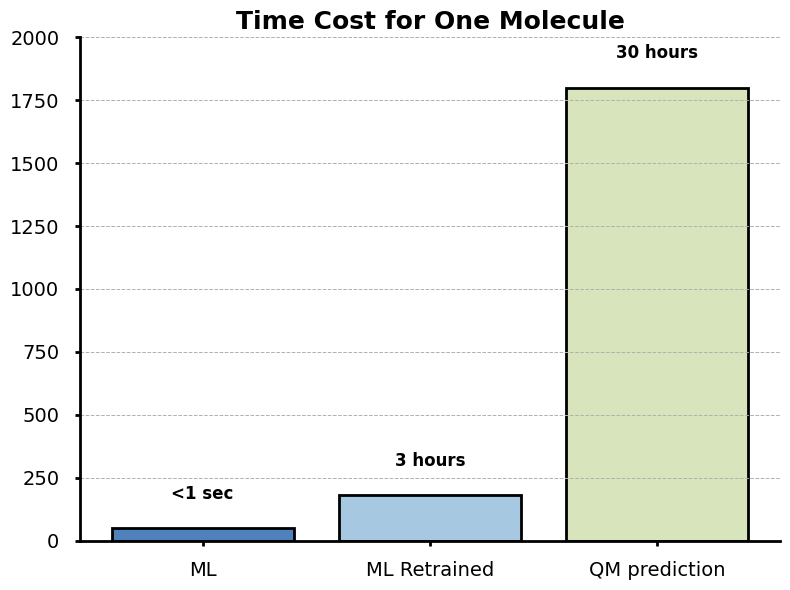

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Данные для графика
labels = ['ML', 'ML Retrained', 'QM prediction']
time_costs = [50, 3*60, 30*60]  # время в минутах
colors = ['#4f81bd', '#a6c8e1', '#d8e4bc']  # Цвета столбцов '#d9d9d9', '#fde9a9',

# Использование стиля 'seaborn-whitegrid' для чистого и современного вида
plt.style.use('seaborn-v0_8-poster')

# Построение столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8, 6))

# Создание столбцов с черной границей
bars = ax.bar(labels, time_costs, color=colors, edgecolor='black', linewidth=2)

# Подписи на столбцах
for bar, time_cost in zip(bars, time_costs):
    time_label = f'{time_cost / 60:.0f} hours' if time_cost >= 60 else '< 1 hours' if time_cost == 5 else '<1 sec'
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, time_label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Настройки осей
#ax.set_ylabel('Time Cost (minutes)', fontsize=16, fontweight='bold')
ax.set_title('Time Cost for One Molecule', fontsize=18, fontweight='bold')
ax.set_ylim(0, 2000)  # Пределы оси Y

# Настройка шрифтов для осей
ax.tick_params(axis='x', labelsize=14, width=2)
ax.tick_params(axis='y', labelsize=14, width=2)

# Удаление верхней и правой границ графика для более современного вида
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Толщина нижней и левой границ
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Добавление сетки для оси Y
ax.yaxis.grid(True, linestyle='--', linewidth=0.7)

# Сохранение графика в высоком качестве
plt.tight_layout()
plt.savefig('time_cost_chart_publication.png', dpi=300)

# Показ графика
plt.show()

In [27]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']